In [37]:
import pandas as pd


In [38]:
df = pd.read_excel(
    "Pedidos.xlsx",
    parse_dates=["DataFechamento"]  # Converte diretamente essa coluna para datetime
)
df.head()

,codigo_produto,descricao_produto,codigo_subcategoria,descricao_subcategoria,codigo_categoria,descricao_categoria,qtde_vendida,valor_unitario,acrescimos,descontos,valor_total,ordem_item,numero_pedido,valor_pedido,DataFechamento
0,709,SKOL LATA,61,CERVEJAS,18,BEBIDAS,1.0,4.0,0.0,0.0,4.0,1,290916,6.5,2017-01-31 21:16:23.060000000
1,710,CONTI GUARANA LATA,62,REFRIGERANTES,18,BEBIDAS,1.0,2.5,0.0,0.0,2.5,2,290916,6.5,2017-01-31 21:16:23.060000000
2,712,DOGAO 1,64,PAO DE HAMBURGUER,19,LANCHES,1.0,15.0,0.0,0.0,15.0,1,290918,19.0,2017-01-31 21:54:56.006666700
3,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,1,290919,22.0,2017-01-31 18:39:32.210000000
4,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,2,290919,22.0,2017-01-31 18:39:32.210000000


In [39]:
# pega todas as colunas numéricas
num_cols = df.select_dtypes(include="number").columns

# remove qtde_vendida da lista
num_cols = num_cols.drop("qtde_vendida")

# arredonda apenas as numéricas restantes
df[num_cols] = df[num_cols].round(2)

df.head()


,codigo_produto,descricao_produto,codigo_subcategoria,descricao_subcategoria,codigo_categoria,descricao_categoria,qtde_vendida,valor_unitario,acrescimos,descontos,valor_total,ordem_item,numero_pedido,valor_pedido,DataFechamento
0,709,SKOL LATA,61,CERVEJAS,18,BEBIDAS,1.0,4.0,0.0,0.0,4.0,1,290916,6.5,2017-01-31 21:16:23.060000000
1,710,CONTI GUARANA LATA,62,REFRIGERANTES,18,BEBIDAS,1.0,2.5,0.0,0.0,2.5,2,290916,6.5,2017-01-31 21:16:23.060000000
2,712,DOGAO 1,64,PAO DE HAMBURGUER,19,LANCHES,1.0,15.0,0.0,0.0,15.0,1,290918,19.0,2017-01-31 21:54:56.006666700
3,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,1,290919,22.0,2017-01-31 18:39:32.210000000
4,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,2,290919,22.0,2017-01-31 18:39:32.210000000


In [40]:
# Dimensão
print("Formato:", df.shape)

# Tipos de dados
print("\nTipos:")
print(df.dtypes)

# Estatísticas numéricas
print("\nEstatísticas:")
print(df.describe())

# Ver valores nulos
print("\nNulos:")
print(df.isnull().sum()) 


Formato: (1048575, 15)

Tipos:
codigo_produto                     int64
descricao_produto                 object
codigo_subcategoria                int64
descricao_subcategoria            object
codigo_categoria                   int64
descricao_categoria               object
qtde_vendida                     float64
valor_unitario                   float64
acrescimos                       float64
descontos                        float64
valor_total                      float64
ordem_item                         int64
numero_pedido                      int64
valor_pedido                     float64
DataFechamento            datetime64[ns]
dtype: object

Estatísticas:
       codigo_produto  codigo_subcategoria  codigo_categoria  qtde_vendida  \
count    1.048575e+06         1.048575e+06      1.048575e+06  1.048575e+06   
mean     7.571760e+02         6.484381e+01      1.883448e+01  1.208557e+00   
min      7.090000e+02         6.100000e+01      1.800000e+01 -2.900000e+01   
25%      7.17

In [41]:
# Ver linhas com valores negativos
linhas_removidas = (df["qtde_vendida"] < 0).sum()
print("Linhas a remover:", linhas_removidas)

df = df[df["qtde_vendida"] >= 0].copy()  

df = df[df["DataFechamento"].dt.year < 2025].copy()


Linhas a remover: 14


In [42]:
df = df.drop_duplicates()

In [43]:
df["valor_calculado"] = df["qtde_vendida"] * df["valor_unitario"] + df["acrescimos"] - df["descontos"]

# Diferença entre o calculado e o informado
df["diferenca"] = (df["valor_total"] - df["valor_calculado"]).round(2)

# Conferir registros inconsistentes
inconsistentes = df[df["diferenca"] != 0]


In [44]:
# Dimensão
print("Formato:", df.shape)

Formato: (1048561, 17)


In [45]:
from scipy import stats

# Z-score da coluna 'valor_pedido'
z_scores = stats.zscore(df['valor_pedido'])
df_sem_outliers = df[(z_scores > -3) & (z_scores < 3)]


In [46]:
 
# --- Agregações solicitadas ---
total_pedidos = df_sem_outliers['numero_pedido'].nunique()
valor_medio_pedido = df_sem_outliers['valor_pedido'].mean()
maior_valor_pedido = df_sem_outliers['valor_pedido'].max()
menor_valor_pedido = df_sem_outliers['valor_pedido'].min()
total_itens_vendidos = df_sem_outliers['qtde_vendida'].sum()

# Vendas por categoria
vendas_por_categoria = df_sem_outliers.groupby('descricao_categoria')['valor_total'].sum().reset_index()
vendas_por_categoria = vendas_por_categoria.rename(columns={'valor_total': 'vendas_categoria'})

# Vendas ano a ano
df_sem_outliers['ano'] = df_sem_outliers['DataFechamento'].dt.year
vendas_ano_a_ano = df_sem_outliers.groupby('ano')['valor_total'].sum().reset_index()
vendas_ano_a_ano = vendas_ano_a_ano.rename(columns={'valor_total': 'vendas_ano'})

# Criando um DataFrame resumo geral
resumo_geral = pd.DataFrame({
    'total_pedidos': [total_pedidos],
    'valor_medio_pedido': [valor_medio_pedido],
    'maior_valor_pedido': [maior_valor_pedido],
    'menor_valor_pedido': [menor_valor_pedido],
    'total_itens_vendidos': [total_itens_vendidos]
})

# Mostrando os resultados
print("📊 Resumo Geral:")
print(resumo_geral)
print("\n🏷️ Vendas por categoria:")
print(vendas_por_categoria)
print("\n📅 Vendas ano a ano:")
print(vendas_ano_a_ano)


📊 Resumo Geral:
   total_pedidos  valor_medio_pedido  maior_valor_pedido  menor_valor_pedido  \
0         449122           57.323896               698.0                0.03   

   total_itens_vendidos  
0            1254429.63  

🏷️ Vendas por categoria:
  descricao_categoria  vendas_categoria
0          ACRESCIMOS          12665.52
1        BATATA FRITA          48224.03
2             BEBIDAS        1693709.61
3     D i v e r s o s         133560.68
4               FRIOS           1418.80
5             HOT DOG           1460.00
6             LANCHES       16770651.07
7                  MP            408.64
8               doces           1317.15
9            salgados          22569.28

📅 Vendas ano a ano:
    ano  vendas_ano
0  2017  1326481.12
1  2018  1918827.22
2  2019  1997865.75
3  2020  2471252.19
4  2021  2708327.41
5  2022  3326410.21
6  2023  3967744.51
7  2024   969076.37


/tmp/ipykernel_1058/1786364039.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_outliers['ano'] = df_sem_outliers['DataFechamento'].dt.year


In [47]:
print("\n📅 Vendas ano a ano:")
print(vendas_ano_a_ano)


📅 Vendas ano a ano:
    ano  vendas_ano
0  2017  1326481.12
1  2018  1918827.22
2  2019  1997865.75
3  2020  2471252.19
4  2021  2708327.41
5  2022  3326410.21
6  2023  3967744.51
7  2024   969076.37


In [48]:
total_itens_diferentes = df['codigo_produto'].nunique()
print("🛒 Total de itens diferentes:", total_itens_diferentes)

🛒 Total de itens diferentes: 377


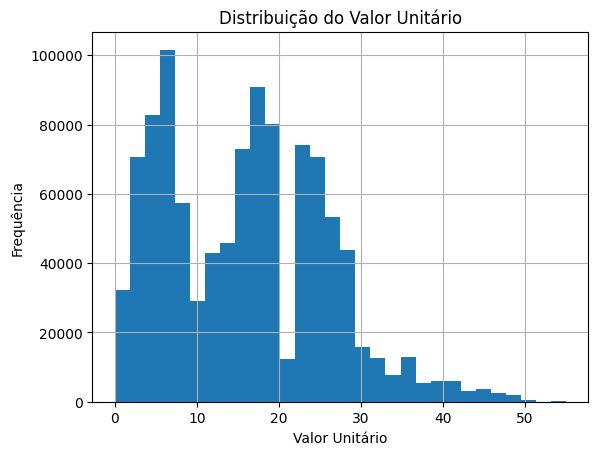

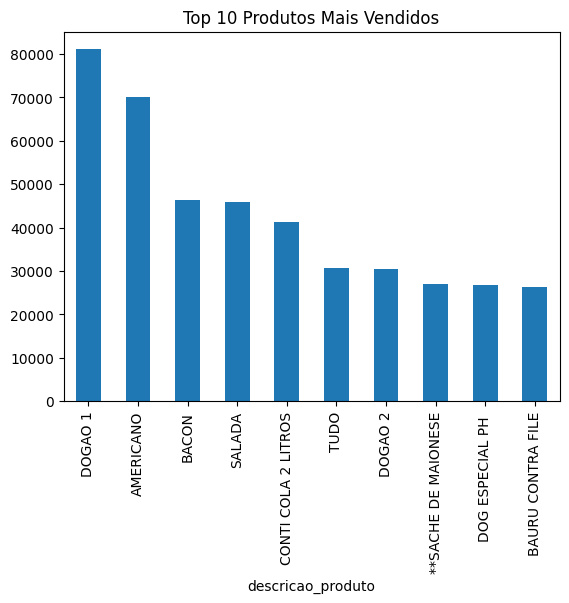

In [49]:
import matplotlib.pyplot as plt

# Histograma de valores unitários
df_sem_outliers["valor_unitario"].hist(bins=30)
plt.title("Distribuição do Valor Unitário")
plt.xlabel("Valor Unitário")
plt.ylabel("Frequência")
plt.show()

# Top 10 produtos mais vendidos
df_sem_outliers["descricao_produto"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Produtos Mais Vendidos")
plt.show()


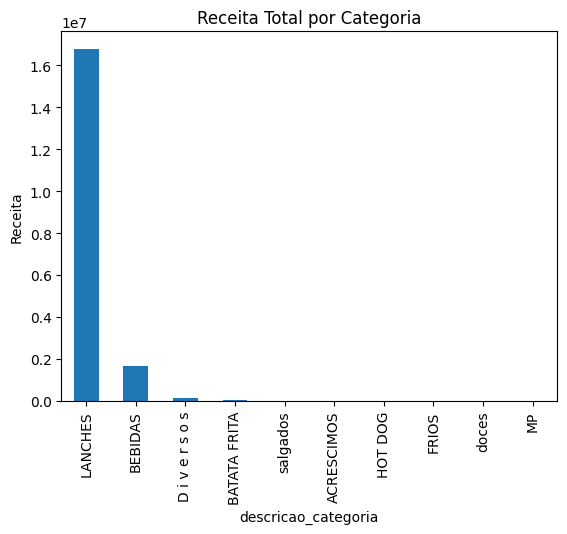

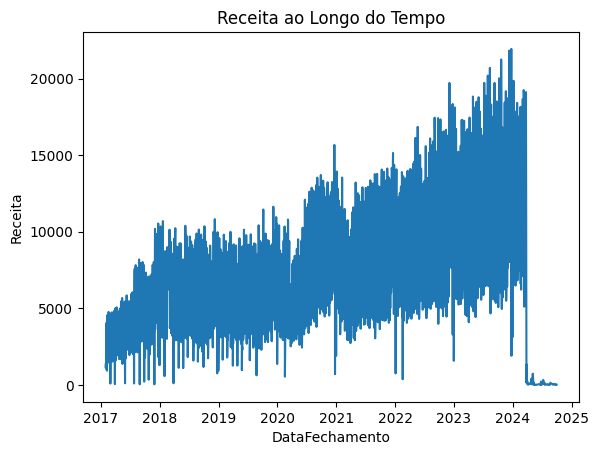

In [50]:
# Receita total por categoria
df_sem_outliers.groupby("descricao_categoria")["valor_total"].sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Receita Total por Categoria")
plt.ylabel("Receita")
plt.show()

# Receita ao longo do tempo
df_sem_outliers.groupby(df_sem_outliers["DataFechamento"].dt.date)["valor_total"].sum().plot()
plt.title("Receita ao Longo do Tempo")
plt.ylabel("Receita")
plt.show()


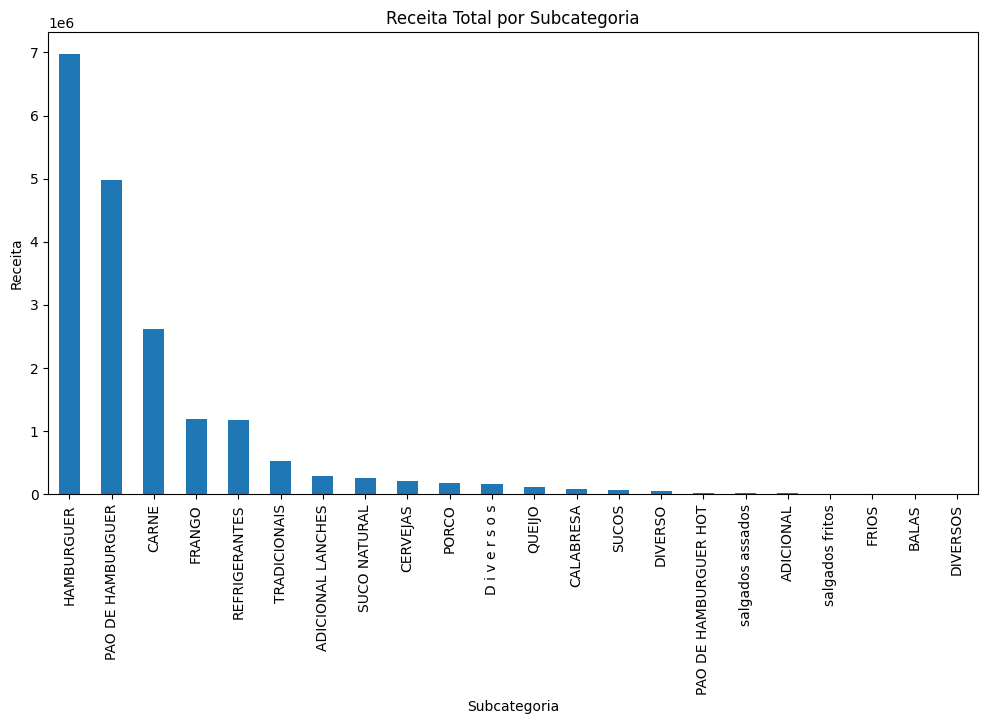

In [51]:
import matplotlib.pyplot as plt

# ================================
# Receita total por subcategoria
# ================================
df.groupby("descricao_subcategoria")["valor_total"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(12,6))
plt.title("Receita Total por Subcategoria")
plt.ylabel("Receita")
plt.xlabel("Subcategoria")
plt.xticks(rotation=90)
plt.show()
 


/tmp/ipykernel_1058/1949599706.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vendas_categoria.index, y=vendas_categoria.values, palette="viridis")


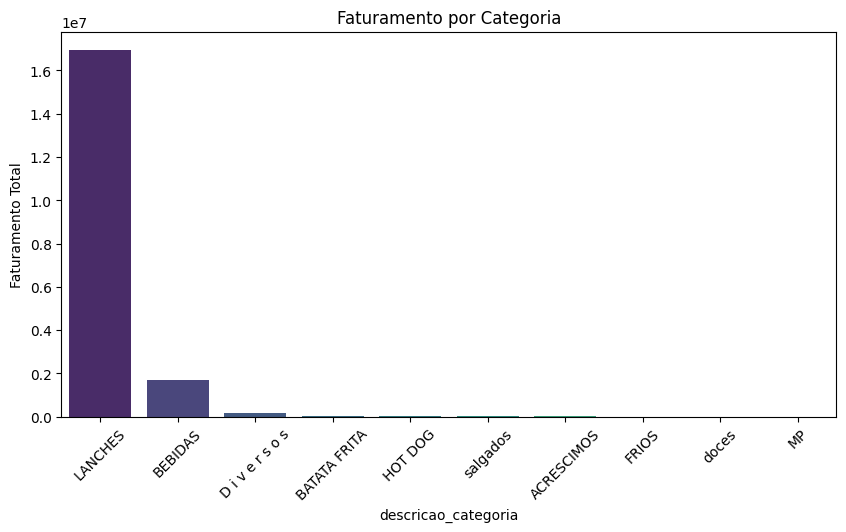

In [52]:
import seaborn as sns

# Total vendido por categoria
vendas_categoria = df.groupby("descricao_categoria")["valor_total"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=vendas_categoria.index, y=vendas_categoria.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Faturamento Total")
plt.title("Faturamento por Categoria")
plt.show()


/tmp/ipykernel_1058/1589170466.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_produtos.index, y=top_produtos.values, palette="magma")


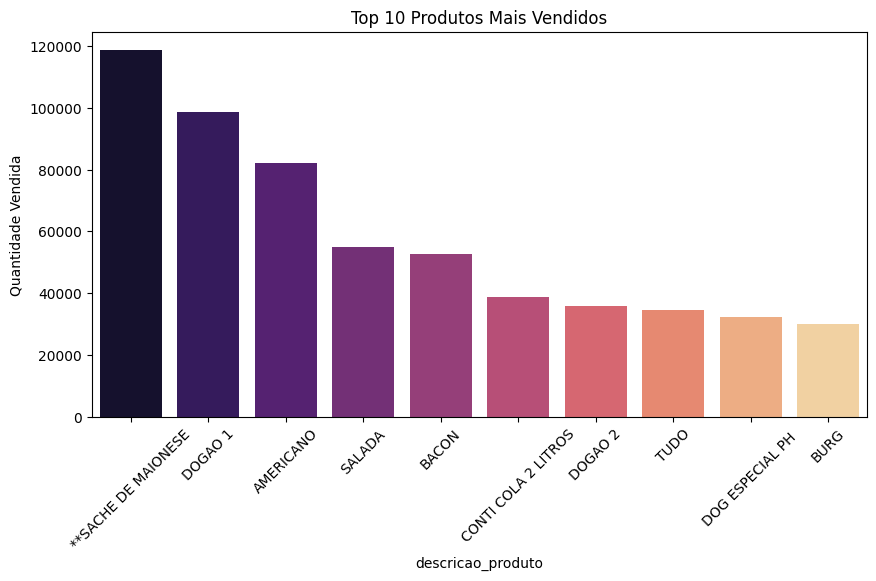

In [53]:
# Top 10 produtos por quantidade vendida
top_produtos = df.groupby("descricao_produto")["qtde_vendida"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_produtos.index, y=top_produtos.values, palette="magma")
plt.xticks(rotation=45)
plt.ylabel("Quantidade Vendida")
plt.title("Top 10 Produtos Mais Vendidos")
plt.show()


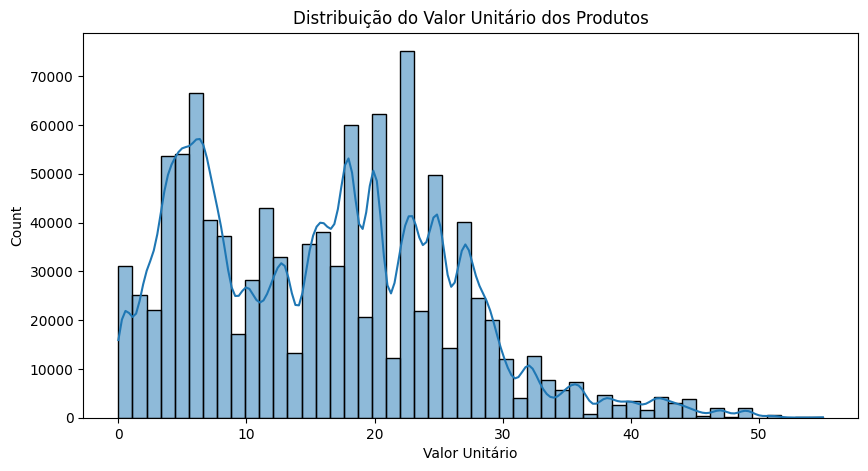

In [54]:
plt.figure(figsize=(10,5))
sns.histplot(df["valor_unitario"], bins=50, kde=True)
plt.xlabel("Valor Unitário")
plt.title("Distribuição do Valor Unitário dos Produtos")
plt.show()


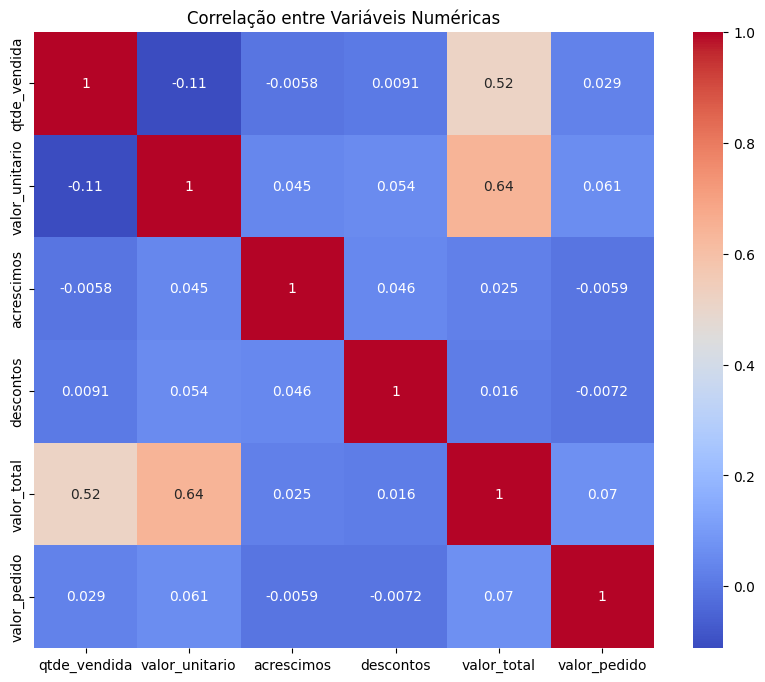

In [55]:
plt.figure(figsize=(10,8))
sns.heatmap(df[["qtde_vendida","valor_unitario","acrescimos","descontos","valor_total","valor_pedido"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Numéricas")
plt.show()


In [56]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# 1️⃣ Criar matriz binária pedido x produto
matriz_binaria = df.pivot_table(
    index='numero_pedido',
    columns='descricao_produto',
    values='qtde_vendida',
    fill_value=0
).applymap(lambda x: 1 if x > 0 else 0)

# 2️⃣ Filtrar os 100 produtos mais vendidos
top_100_produtos = df.groupby('descricao_produto')['qtde_vendida'].sum().sort_values(ascending=False).head(100).index
matriz_top100 = matriz_binaria[top_100_produtos]

# 3️⃣ Aplicar Apriori para conjuntos maiores
frequent_itemsets = apriori(
    matriz_top100,
    min_support=0.005,   # itemset deve aparecer em pelo menos 1% dos pedidos
    use_colnames=True,
    max_len=5           # pegando conjuntos de até 5 produtos
)

# 4️⃣ Gerar regras de associação mais completas
regras = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
).sort_values(by=['confidence', 'lift'], ascending=False)

# 5️⃣ Criar uma matriz de relações entre todos os produtos
# Inicializa DataFrame vazio
produtos = matriz_top100.columns.tolist()
matriz_relacoes = pd.DataFrame(0, index=produtos, columns=produtos, dtype=float)

# Preenche a matriz com a confiança das regras
for _, row in regras.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    for a in antecedents:
        for c in consequents:
            if a != c:
                matriz_relacoes.loc[a, c] = max(matriz_relacoes.loc[a, c], row['confidence'])



/tmp/ipykernel_1058/3435183503.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: 1 if x > 0 else 0)
/home/brunobersan/miniconda3/envs/tf/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [57]:
# 6️⃣ Função para pegar os top N produtos relacionados
def produtos_relacionados_avancado_multi(produtos_input, n=5):
    """
    Retorna os n produtos mais relacionados a um ou mais produtos.
    
    produtos_input: str ou lista de str
    n: número de produtos relacionados a retornar
    """
    if isinstance(produtos_input, str):
        produtos_input = [produtos_input]
    
    # Verifica se os produtos existem na matriz
    produtos_validos = [p for p in produtos_input if p in matriz_relacoes.index]
    if not produtos_validos:
        return f"Nenhum dos produtos informados foi encontrado na matriz."

    # Soma as relações dos produtos informados
    soma_relacoes = matriz_relacoes.loc[produtos_validos].sum(axis=0)
    
    # Remove os próprios produtos da lista
    soma_relacoes = soma_relacoes.drop(produtos_validos, errors='ignore')
    
    # Filtra apenas produtos com relação > 0 e ordena
    soma_relacoes = soma_relacoes[soma_relacoes > 0].sort_values(ascending=False)
    
    return soma_relacoes.head(n)

# Realizando "Predição" com Apriori 
print(produtos_relacionados_avancado_multi(["DOGAO 1", "SALADA"])) 

CONTI COLA 2 LITROS    0.118331
BACON                  0.104443
BURG                   0.075049
**SACHE DE MAIONESE    0.072268
dtype: float64


In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from itertools import product
from sklearn.metrics import make_scorer
import time
from collections import defaultdict
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import ParameterSampler

In [59]:
print("Versão TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponíveis:", gpus)

if gpus:
    print("TensorFlow detectou a GPU!")
else:
    print("Nenhuma GPU detectada.")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Versão TensorFlow: 2.20.0
GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow detectou a GPU!
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17671450710621904731
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14211350528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12709153258487233674
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1758899734.404323    1058 gpu_device.cc:2020] Created device /device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [60]:
df_sem_outliers.head()

,codigo_produto,descricao_produto,codigo_subcategoria,descricao_subcategoria,codigo_categoria,descricao_categoria,qtde_vendida,valor_unitario,acrescimos,descontos,valor_total,ordem_item,numero_pedido,valor_pedido,DataFechamento,valor_calculado,diferenca,ano
0,709,SKOL LATA,61,CERVEJAS,18,BEBIDAS,1.0,4.0,0.0,0.0,4.0,1,290916,6.5,2017-01-31 21:16:23.060000000,4.0,0.0,2017
1,710,CONTI GUARANA LATA,62,REFRIGERANTES,18,BEBIDAS,1.0,2.5,0.0,0.0,2.5,2,290916,6.5,2017-01-31 21:16:23.060000000,2.5,0.0,2017
2,712,DOGAO 1,64,PAO DE HAMBURGUER,19,LANCHES,1.0,15.0,0.0,0.0,15.0,1,290918,19.0,2017-01-31 21:54:56.006666700,15.0,0.0,2017
3,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,1,290919,22.0,2017-01-31 18:39:32.210000000,11.0,0.0,2017
4,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,2,290919,22.0,2017-01-31 18:39:32.210000000,11.0,0.0,2017


In [61]:
# =============================
# FUNÇÕES DE PREPARAÇÃO E MÉTRICAS
# =============================

def create_sequences_and_labels(sequences, max_len):
    """
    Cria sub-sequências de treinamento e seus rótulos.
    Ex: para [1,2,3,4], cria ([1],2), ([1,2],3), ([1,2,3],4)
    """
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append(seq[:i][-max_len:])
            y.append(seq[i])
    return X, y

def recall_at_k(y_true, y_pred_probs, k=10):
    hits = 0
    for true_label, pred_probs in zip(y_true, y_pred_probs): # percorre cada exemplo
        top_k_indices = np.argsort(pred_probs)[::-1][:k] # pega os k produtos mais prováveis
        if true_label in top_k_indices: # verifica se o produto real está entre eles
            hits += 1
    return hits / len(y_true) # divide pelo total para obter proporção de acertos


# Mean Reciprocal Rank (Média do inverso da posição do item correto)
# Para cada previsão, olha em que posição o produto correto apareceu no top-k.
# Se está na posição 1 → 1/1 = 1
# Se está na posição 3 → 1/3 ≈ 0.33
# Se não está → 0
# Depois tira a média.
# Avalia não só se acertou, mas quão cedo acertou no top-k.
def mrr_at_k(y_true, y_pred_probs, k=10):
    rr_sum = 0
    for true_label, pred_probs in zip(y_true, y_pred_probs):
        top_k_indices = np.argsort(pred_probs)[::-1][:k]
        try:
            rank = np.where(top_k_indices == true_label)[0][0] + 1
            rr_sum += 1.0 / rank
        except IndexError:
            pass
    return rr_sum / len(y_true)


# NDCG = Normalized Discounted Cumulative Gain
# Avalia qualidade do ranking das previsões: acertos no topo contam mais do que acertos lá no final do top-k.
# Se o item correto está no início → mais pontos; se está no fim → menos pontos.
# Normaliza para que o valor fique entre 0 e 1.

def ndcg_at_k(y_true, y_pred_probs, k=10):
    ndcg_sum = 0
    for true_label, pred_probs in zip(y_true, y_pred_probs):
        top_k_indices = np.argsort(pred_probs)[::-1][:k]
        dcg = 0
        if true_label in top_k_indices:
            rank = np.where(top_k_indices == true_label)[0][0]
            dcg = 1.0 / np.log2(rank + 2)
        idcg = 1.0 / np.log2(0 + 2)
        ndcg_sum += dcg / idcg
    return ndcg_sum / len(y_true)


## Função da camada Embedding

### A camada embedding transforma cada produto (um número inteiro) em um vetor denso contínuo ( embedding_dim dimensões )
1. Reduz a esparsidade e ajuda a rede a capturar relações semânticas entre produtos
2. Usar Embeddings permite treinar representações de produtos mais informativas que o One-hot encoding.


## Diferença entre usar LSTM e GRU 

A LSTM tem três portas ( Entrada, saída e esquecimento ), permitindo melhorar a captura de dependências de longo prazo.
O Código permite alternar entre ambas, testando qual se adapta melhor ao problema


## Parametros Dropout e Recurrent_dropout

Dropout desliga aleatoriamente conexões da entrada da célula -> Reduz overfitting
Recurrent_dropout desliga conexões internas entre passos de tempo -> regula dependencias temporais 
Permite um ajuste fino do controle de overfitting.


## Por que a saída do modelo utiliza Dense com softmax? 

O Dense final retorna uma probabilidade para cada produto do vocabulário
Softmax garante que as probabilidades somem 1
Como o objetivo é prever o próximo produto na sequência, trata-se de um problema de classificação multiclasse.


## Por que foi escolhido o otimizador Adam? 

Adam combina RMSProp + Momuntum, adaptando a taxa de aprendizado para cada parâmetro. 
É robusto, rápido e reduz necessidade de tunagem manual
Usar o adam converge melhor em dados de séries temporais/discretas


## Uso de sparse_categorical_crossentropy

Usada quando os rótulos são inteiros ( não one-hot)
Se fosse categorical_crossentropy, seria necessário converter o Y para one-hot encoding
Manter labels inteiros economiza memória e processamento.


## Treinamento - Papel do EarlyStopping

Interrompe o treino se val_loss não melhorar após 'patience' épocas.
restaure_best_weights restaura os pesos do melhor ponto. Evitar overfitting e economizar tempo computacional


## Aumento de epocas com o uso de Early Stopping

Se Early stopping para antes, não há custo extra. Caso o modelo precise de mais epocas para convergir, não fica limitado. Deixar epochs mais alto e confiar no early stopping para evitar overfitting e garantir um treinamento eficiente.


## Batch_zike

Numero de exemplos de processados antes de atualizar os pesos. Batchs grandes refletem um treino mais estável, mas requer mais memória. Batch pequeno gera treinos mais ruidosos. Decisão 46500 é grande, bom aproveitamento do hardware GPU/TPU


## Por que Recall@k como métrica?

Medimos se o item correto está entre os K mais prováveis. Mais relevante para sistemas de recomendação, já que prever exatamente 1 item pode ser muito dificil.
Recall@10 é um padrão quando se trata de sistemas de recomendação.


## Predict e Predict Proba

1. proba: Retorna a distribuição de probabilidades
2. predict: retorna apenas o índice mais provável
Expor ambos permite análise probabilistica ou classificação direta.


## Grid search manual

estamos variando no grid: embedding_dim, hidden_units, dropout, recurrent_dropout, lr

1. Varia dimensão dos embeddings, tamanho da rede, regularização e taxa de aprendizado. Objetivo é encontrar o melhor balanço entre capacidade do modelo e generalização
2. medimos o tempo para ter uma noção de custo operacional que também é importante.


## Comparando GRU e LSTM

GRU treina mais rápido e apresentou resultados melhores. Achamos que isso se dá por conta das sequencias dos pedidos do cliente não serem muito longas. A LSTM é mais expressiva, porém é mais lenta e apresentou um desempenho pior no Recall@10 em N estudos de grid que fizemos.

Aplicamos ainda assim o treinamento com os dois modelos para termos o conhecimento empírico e não apenas teórico.

## Resumo

O Experimento foi desenhado para testar arquiteturas recorrentes (GRU e LSTM) de forma modular e com busca manual de hiperparâmetros. Ele equilibra capacidade de modelagem (hidden_units, embeddings), generalização (dropout, recurrent_dropout, early stopping) e eficiência computacional (batch_size grande, medição de tempo).



In [62]:

# =============================
# MODELO (Wrapper simples)
# =============================
# vocab_size → quantos produtos diferentes existem (+1 para padding)
# max_len → tamanho máximo das sequências
# embedding_dim → tamanho do vetor que representa cada produto
# hidden_units → neurônios na camada LSTM/GRU
# dropout → “desliga” aleatoriamente X% dos neurônios durante treino
# recurrent_dropout → mesmo que dropout, mas só nas conexões internas da LSTM/GRU
# cell_type → tipo de camada: 'LSTM' ou 'GRU'
# lr → learning rate do Adam
# batch_size → quantidade de exemplos processados por vez
# epochs → número de vezes que passa por todo o treino
# patience → quantas épocas sem melhorar para parar (early stopping)

class KerasRecurrentClassifier:
    def __init__(self, vocab_size, max_len, embedding_dim=32, hidden_units=32,
                 dropout=0.2, recurrent_dropout=0.0, cell_type='LSTM',
                 lr=1e-3, batch_size=32, epochs=20, patience=3):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.cell_type = cell_type
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.model = None

    # =============================
    # Aqui está o coração do modelo: a rede que olha para a sequência
    # LSTM/GRU: memoriza padrões ao longo da sequência de produtos
    def build_model(self):
        model = Sequential()

            # Camada de Embedding: transforma cada produto em um vetor denso
        model.add(Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_len
        ))

        # Camada recorrente (LSTM ou GRU)
        if self.cell_type == 'LSTM':
            model.add(LSTM(
                self.hidden_units,
                activation='tanh',  # ativação explícita
                dropout=self.dropout,
                recurrent_dropout=self.recurrent_dropout
            ))
        elif self.cell_type == 'GRU':
            model.add(GRU(
                self.hidden_units,
                activation='tanh',
                dropout=self.dropout,
                recurrent_dropout=self.recurrent_dropout
            ))

        # Camada densa extra para mais poder de representação
        model.add(Dense(self.hidden_units, activation='relu'))

        # Camada de saída
        model.add(Dense(self.vocab_size, activation='softmax'))

        # Otimizador
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        # Compilação
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer
            )

        return model
    


    def fit(self, X, y, val_data=None):
        self.model = self.build_model()
        X_padded = pad_sequences(X, maxlen=self.max_len, padding='pre')

        callbacks = [EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)] # Para o treino se não melhorar por patience épocas e restaura o melhor modelo

        # Prepara os dados de validação, se houver
        if val_data:
            X_val, y_val = val_data
            X_val_padded = pad_sequences(X_val, maxlen=self.max_len, padding='pre')
            val_data_tuple = (X_val_padded, np.array(y_val))
        else:
            val_data_tuple = None

        #Treina o modelo
        history = self.model.fit(
            X_padded, np.array(y),
            validation_data=val_data_tuple,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=callbacks,
            verbose=0
        )
        return history

    # Recebe sequências e retorna as probabilidades de cada produto ser o próximo
    def predict_proba(self, X):
        X_padded = pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict(X_padded, verbose=0)

    # Retorna o produto mais provável (índice do maior valor)
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    # Avalia o modelo usando Recall@k
    def score(self, X, y, k=10):
        y_pred_probs = self.predict_proba(X)
        return recall_at_k(np.array(y), y_pred_probs, k=k)

In [63]:

# =============================
# PREPARAÇÃO DOS DADOS
# =============================
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.keras import TqdmCallback
import time
from itertools import product

 
unique_products = df_sem_outliers['codigo_produto'].unique() # -- Obtem uma lista de produtos únicos
product_to_int = {product: i + 1 for i, product in enumerate(unique_products)} # Cria um dicionário que transforma cada código de produto em um número inteiro. i + 1 garante que o índice comece em 1 (não usamos 0 porque geralmente reservamos 0 para padding).
df_sem_outliers['product_id'] = df_sem_outliers['codigo_produto'].map(product_to_int) # Cria uma nova coluna product_id que substitui o código original do produto pelo número inteiro correspondente.


vocab_size = len(product_to_int) + 1 #quantidade de produtos + 1 (porque o índice 0 é reservado para padding).
max_len = 10 # tamanho máximo das sequências de produtos que a rede vai receber (sequências muito longas serão cortadas e sequências curtas serão completadas com 0).

# Split temporal
train_max_date = pd.to_datetime('2022-12-31') 
val_max_date = pd.to_datetime('2023-12-31') 

train_sequences = df_sem_outliers[df_sem_outliers['DataFechamento'] <= train_max_date] \
    .groupby('numero_pedido')['product_id'].apply(list).tolist() # Tudo até 2022-12-31 vai para treino.

val_sequences = df_sem_outliers[(df_sem_outliers['DataFechamento'] > train_max_date) & (df_sem_outliers['DataFechamento'] <= val_max_date)] \
    .groupby('numero_pedido')['product_id'].apply(list).tolist() # De 2023-01-01 até 2023-12-31 vai para validação.

test_sequences = df_sem_outliers[df_sem_outliers['DataFechamento'] > val_max_date] \
    .groupby('numero_pedido')['product_id'].apply(list).tolist() # Depois disso vai para teste.


# Filtrar sequências com mais de 1 item
# Eliminar sequências com apenas 1 item, pois não podem ser usadas para treino pois não há próximo item a prever
train_sequences = [s for s in train_sequences if len(s) > 1]
val_sequences = [s for s in val_sequences if len(s) > 1]
test_sequences = [s for s in test_sequences if len(s) > 1]

# =============================
# ORGANIZAÇÃO DOS CONJUNTOS DE TREINO, VALIDAÇÃO E TESTE
#   Criar X e y usando a função existente
#   Ex: para [1,2,3,4], cria ([1],2), ([1,2],3), ([1,2,3],4)
#   Chama uma função que transforma cada sequência de produtos em pares (X, y) para treino:
#   X = sequência de produtos até o penúltimo produto
#   y = próximo produto que queremos prever
#   🔹 Ex: [1,2,3] vira X=[1,2], y=3
# =============================
X_train, y_train = create_sequences_and_labels(train_sequences, max_len) 
X_val, y_val = create_sequences_and_labels(val_sequences, max_len)
X_test, y_test = create_sequences_and_labels(test_sequences, max_len)



/tmp/ipykernel_1058/6437571.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_outliers['product_id'] = df_sem_outliers['codigo_produto'].map(product_to_int) # Cria uma nova coluna product_id que substitui o código original do produto pelo número inteiro correspondente.


In [64]:
# =============================
# PADDING DAS SEQUÊNCIAS (CORRIGIDO PARA POST)
#   Todas as sequências são ajustadas para ter exatamente max_len produtos.
#   padding='post' → adiciona zeros no final da sequência (compatível com cuDNN).
#   🔹 Ex: [1,2,3] vira [1,2,3,0,0,0,0,0,0,0]
# =============================
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val   = pad_sequences(X_val,   maxlen=max_len, padding='post')
X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post')

# Transformar y em arrays
y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

print("Tamanho das amostras usadas:")
print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))
print("Exemplo de sequência de treino:", X_train[0])



Tamanho das amostras usadas:
Train: 465205
Val: 100256
Test: 23399
Exemplo de sequência de treino: [1 0 0 0 0 0 0 0 0 0]


In [65]:
print(X_train.shape)

(465205, 10)


In [66]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size_val = 46500
epochs_val = 1000   # aumentamos bastante para dar espaço ao early stop
seed = 42

# callback de early stopping
early_stop = EarlyStopping(
    monitor="val_loss",      # pode mudar para outra métrica, ex: "val_recall" se implementado
    patience=10,             # número de épocas sem melhora antes de parar
    restore_best_weights=True # restaura os melhores pesos
)

param_grid = {
    'embedding_dim': [128, 256],
    'hidden_units': [128, 256],
    'dropout': [0.1, 0.2, 0.3],
    'recurrent_dropout': [0.0, 0.1],
    'lr': [1e-3, 5e-4, 1e-4]
}

results = []

for cell_type in ['GRU', 'LSTM']:
    print(f"\n=== Rodando para {cell_type} ===")
    
    all_combinations = list(product(
        param_grid['embedding_dim'],
        param_grid['hidden_units'],
        param_grid['dropout'],
        param_grid['recurrent_dropout'],
        param_grid['lr']
    ))
    
    for i, combo in enumerate(all_combinations):
        params = {
            'embedding_dim': combo[0],
            'hidden_units': combo[1],
            'dropout': combo[2],
            'recurrent_dropout': combo[3],
            'lr': combo[4]
        }
        
        print(f"\n[{i+1}/{len(all_combinations)}] Criando modelo com params: {params}")
        start = time.time()
        
        clf = KerasRecurrentClassifier(
            vocab_size=vocab_size,
            max_len=max_len,
            cell_type=cell_type,
            batch_size=batch_size_val,
            epochs=5000,     # Aumentamos bastante para o early stopping trabalhar
            patience=10,     # Early stop embutido no wrapper
            **params
        )
        
        clf.fit(
            X_train, y_train,
            val_data=(X_val, y_val) # aqui entra o early stopping
        )
        
        score = clf.score(X_val, y_val, k=10)
        elapsed = time.time() - start
        print(f"{cell_type} {params} -> Recall@10: {score:.4f} | Tempo: {elapsed/60:.2f} min")
        results.append((cell_type, params, score))



=== Rodando para GRU ===

[1/72] Criando modelo com params: {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.001}


/home/brunobersan/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


GRU {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.001} -> Recall@10: 0.4516 | Tempo: 8.66 min

[2/72] Criando modelo com params: {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.0005}
GRU {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.0005} -> Recall@10: 0.3762 | Tempo: 1.62 min

[3/72] Criando modelo com params: {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.0001}
GRU {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.0, 'lr': 0.0001} -> Recall@10: 0.3758 | Tempo: 3.28 min

[4/72] Criando modelo com params: {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.1, 'lr': 0.001}
GRU {'embedding_dim': 128, 'hidden_units': 128, 'dropout': 0.1, 'recurrent_dropout': 0.1, 'lr': 0.001} -> Recall@10: 0.4488 | Tempo: 2.12 min

[5/72] Criando modelo com


--- Melhor Modelo ---
('GRU', {'embedding_dim': 256, 'hidden_units': 128, 'dropout': 0.3, 'recurrent_dropout': 0.0, 'lr': 0.001}, 0.4574688796680498)


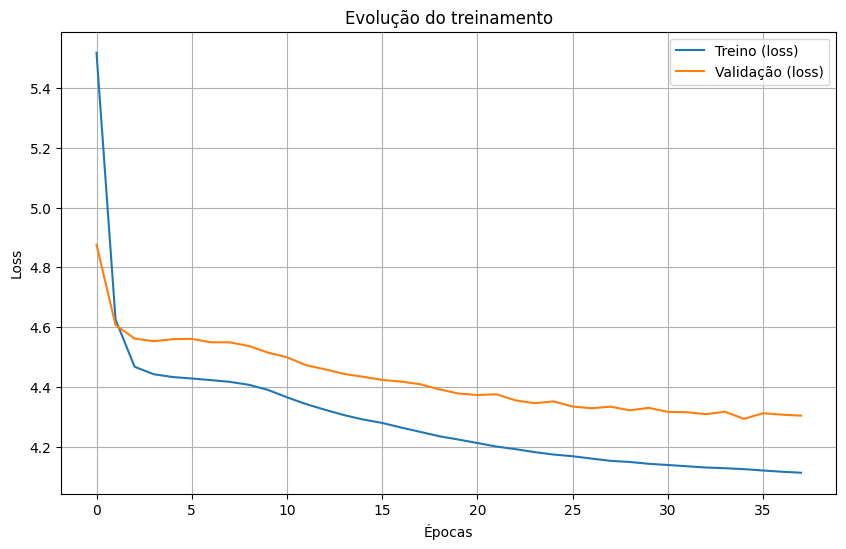


--- Métricas no Teste ---
Recall@5: 0.30035471601350483
Recall@10: 0.4358305910508996
MRR@10: 0.1882312837951976
NDCG@10: 0.24605624571098722


In [91]:
import matplotlib.pyplot as plt

# =============================
# MELHOR MODELO
# =============================
best = max(results, key=lambda x: x[2])
print("\n--- Melhor Modelo ---")
print(best)

best_clf = KerasRecurrentClassifier(
    vocab_size=vocab_size,
    max_len=max_len,
    cell_type=best[0],
    batch_size=batch_size_val,
    epochs=10000,
    **best[1]
)

# 🔹 Salvar histórico
history = best_clf.fit(
    X_train, y_train,
    val_data=(X_val, y_val)
)

# =============================
# PLOT LEARNING CURVES
# =============================
plt.figure(figsize=(10, 6))

plt.plot(history.history["loss"], label="Treino (loss)")
plt.plot(history.history["val_loss"], label="Validação (loss)")

plt.title("Evolução do treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# AVALIAÇÃO FINAL
# =============================
y_pred_probs = best_clf.predict_proba(X_test)

print("\n--- Métricas no Teste ---")
print("Recall@5:", recall_at_k(y_test, y_pred_probs, k=5))
print("Recall@10:", recall_at_k(y_test, y_pred_probs, k=10))
print("MRR@10:", mrr_at_k(y_test, y_pred_probs, k=10))
print("NDCG@10:", ndcg_at_k(y_test, y_pred_probs, k=10))


In [72]:
best_clf.model.save("modelo_total_dados_ULTIMO2.h5")

In [73]:
best_clf.model.save("modelo_total_dados_ULTIMO2.keras")

In [89]:
# 🔹 Dicionários de mapeamento
# já deve existir no seu código:
# product_to_int = {sku: idx, ...}
# int_to_product = {idx: sku, ...}

# Sequência inicial (SKU real → índice interno)
seq = [product_to_int[725]]
int_to_product = {v: k for k, v in product_to_int.items()}

for step in range(5):  # gerar 5 próximos itens
    probs = best_clf.predict_proba([seq])[0]

    # 🔹 Zerar a probabilidade de todos os itens já vistos (não repete nada da sequência)
    for item in seq:
        probs[item] = 0

    # Re-normalizar as probabilidades
    probs = probs / probs.sum()

    # Top-5 candidatos
    top5 = np.argsort(probs)[-5:][::-1]

    print(f"\nStep {step+1}:")
    print("Top-5 recomendados (ids internos):", top5, "com probs:", probs[top5])
    print("Top-5 recomendados (SKUs reais):", [int_to_product[i] for i in top5])

    # Escolhe o mais provável do top5
    next_item = top5[0]
    seq.append(next_item)

# Converte sequência inteira de volta para SKUs reais
seq_skus = [int_to_product[i] for i in seq]

print("\nSequência prevista (ids internos):", seq)
print("Sequência prevista (SKUs reais):", seq_skus)



Step 1:
Top-5 recomendados (ids internos): [74  3 27 37  5] com probs: [0.05167769 0.05160542 0.04851647 0.02887418 0.02807574]
Top-5 recomendados (SKUs reais): [782, 712, 711, 745, 714]

Step 2:
Top-5 recomendados (ids internos): [  3  27   5 112   9] com probs: [0.06134357 0.05779582 0.03301826 0.03063825 0.02975428]
Top-5 recomendados (SKUs reais): [712, 711, 714, 820, 718]

Step 3:
Top-5 recomendados (ids internos): [112  27   9   5  37] com probs: [0.05629137 0.05421045 0.04278196 0.03825997 0.03501793]
Top-5 recomendados (SKUs reais): [820, 711, 718, 714, 745]

Step 4:
Top-5 recomendados (ids internos): [ 27   5   9 161  87] com probs: [0.05395303 0.04735144 0.04157235 0.03985203 0.03709515]
Top-5 recomendados (SKUs reais): [711, 714, 718, 869, 795]

Step 5:
Top-5 recomendados (ids internos): [87 89  5 88  9] com probs: [0.06684332 0.05682987 0.05368754 0.03632054 0.03568351]
Top-5 recomendados (SKUs reais): [795, 797, 714, 796, 718]

Sequência prevista (ids internos): [16, 74, 